In [1]:
# train_and_save_xgboost.py

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from xgboost import XGBRegressor
import logging
from xgboost_utils import save_pipeline
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def load_and_preprocess_data():
    """
    Placeholder function to load and preprocess data.
    Replace this with your actual data loading and preprocessing logic.
    
    Returns:
        pd.DataFrame: Preprocessed DataFrame.
    """
    # Example implementation
    df = pd.read_csv('data/LAPS.csv', na_values=['\\N', 'NaN', ''])
    
    # Handle missing values, feature engineering, etc.
    df.fillna(0, inplace=True)
    
    return df

def main():
    # Load and preprocess data
    logging.info("Loading and preprocessing data...")
    df = load_and_preprocess_data()
    logging.info(f"Data loaded with shape: {df.shape}")
    
    # Prepare features and target
    features_to_drop = [
        "cumulative_milliseconds", "positionOrder", "date", "driverRef", "number", 
        "date_race", "time_race", "time", "forename", "surname", "dob", "url_race", 
        "location", "circuitRef"  # Removed "milliseconds" from features_to_drop
    ]
    
    X = df.drop(columns=features_to_drop)
    y = df["milliseconds"]
    logging.info(f"Features and target prepared. X shape: {X.shape}, y shape: {y.shape}")
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    logging.info(f"Data split into train and test sets.")
    logging.info(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
    
    # Define categorical and numerical features
    categorical_features = ["code", "nationality", "status", "circuit_type", "country"]
    numerical_features = [col for col in X.columns if col not in categorical_features]
    logging.info(f"Categorical features: {categorical_features}")
    logging.info(f"Numerical features: {numerical_features}")
    
    # Create preprocessing pipeline including ColumnTransformer and PCA
    preprocessor = Pipeline(steps=[
        ('transformer', ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), numerical_features),
                ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
            ]
        )),
        ('pca', PCA(n_components=100, random_state=42))
    ])
    
    # Create the full pipeline with preprocessor and XGBoost regressor
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', XGBRegressor(n_estimators=100, random_state=42))
    ])
    
    # Train the pipeline
    logging.info("Training XGBoost pipeline...")
    pipeline.fit(X_train, y_train)
    logging.info("Training completed.")
    
    # Save the entire pipeline
    model_path = "models/xgboost_pipeline.pkl"
    save_pipeline(pipeline, model_path)
    logging.info(f"XGBoost pipeline saved to {model_path}")
    
    # Evaluate model performance
    logging.info("Evaluating model performance on test set...")
    y_pred = pipeline.predict(X_test)
    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    logging.info(f"Test RMSE: {rmse:.2f}")
    logging.info(f"Test MAE: {mae:.2f}")
    logging.info(f"Test R²: {r2:.4f}")

if __name__ == "__main__":
    main()


2024-12-01 14:12:14,558 - INFO - Loading and preprocessing data...
2024-12-01 14:12:15,111 - INFO - Data loaded with shape: (129278, 59)
2024-12-01 14:12:15,121 - INFO - Features and target prepared. X shape: (129278, 45), y shape: (129278,)
2024-12-01 14:12:15,145 - INFO - Data split into train and test sets.
2024-12-01 14:12:15,145 - INFO - X_train shape: (103422, 45), X_test shape: (25856, 45)
2024-12-01 14:12:15,146 - INFO - Categorical features: ['code', 'nationality', 'status', 'circuit_type', 'country']
2024-12-01 14:12:15,146 - INFO - Numerical features: ['raceId', 'driverId', 'lap', 'position', 'milliseconds', 'year', 'round', 'circuitId', 'lat', 'lng', 'alt', 'grid', 'statusId', 'pitstop_milliseconds', 'constructorId', 'constructor_points', 'constructor_position', 'constructor_performance', 'circuit_length', 'circuit_type_encoded', 'seconds_from_start', 'TrackStatus', 'tire_compound', 'fp1_median_time', 'fp2_median_time', 'fp3_median_time', 'quali_time', 'is_pit_lap', 'TrackT

2024-12-01 14:12:18,275 - INFO - Pipeline loaded from models/xgboost_pipeline.pkl
2024-12-01 14:12:18,611 - INFO - Numerical features: ['raceId', 'driverId', 'lap', 'position', 'milliseconds', 'year', 'round', 'circuitId', 'lat', 'lng', 'alt', 'grid', 'statusId', 'pitstop_milliseconds', 'constructorId', 'constructor_points', 'constructor_position', 'constructor_performance', 'circuit_length', 'circuit_type_encoded', 'seconds_from_start', 'TrackStatus', 'tire_compound', 'fp1_median_time', 'fp2_median_time', 'fp3_median_time', 'quali_time', 'is_pit_lap', 'TrackTemp', 'AirTemp', 'Humidity', 'driver_aggression', 'driver_overall_skill', 'driver_circuit_skill', 'driver_consistency', 'driver_reliability', 'driver_risk_taking', 'tire_age', 'fuel_load', 'track_position']
2024-12-01 14:12:18,611 - INFO - Categorical features: ['code', 'nationality', 'status', 'circuit_type', 'country']
2024-12-01 14:12:18,699 - INFO - Initialized 19 drivers for raceId 1000
2024-12-01 14:12:18,699 - INFO - Simula

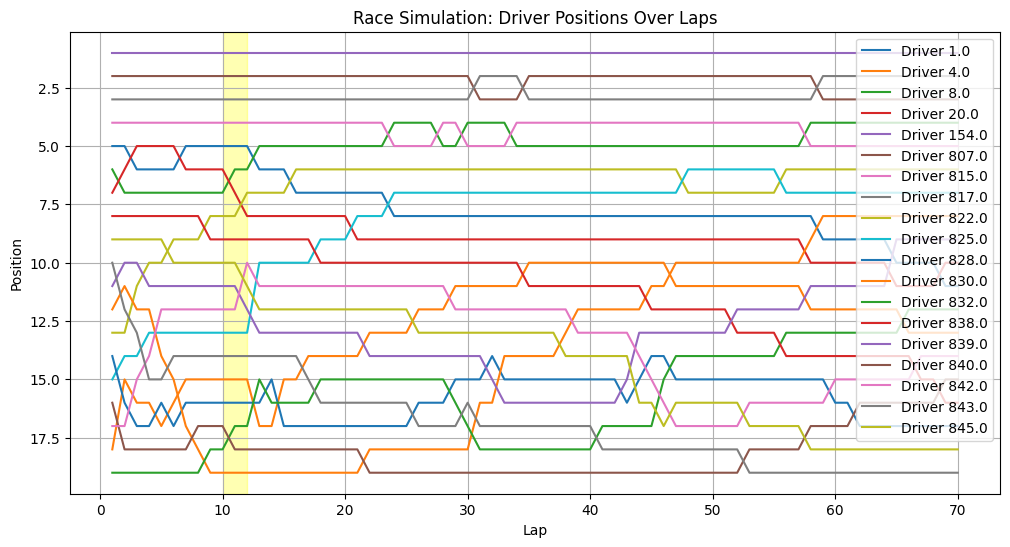

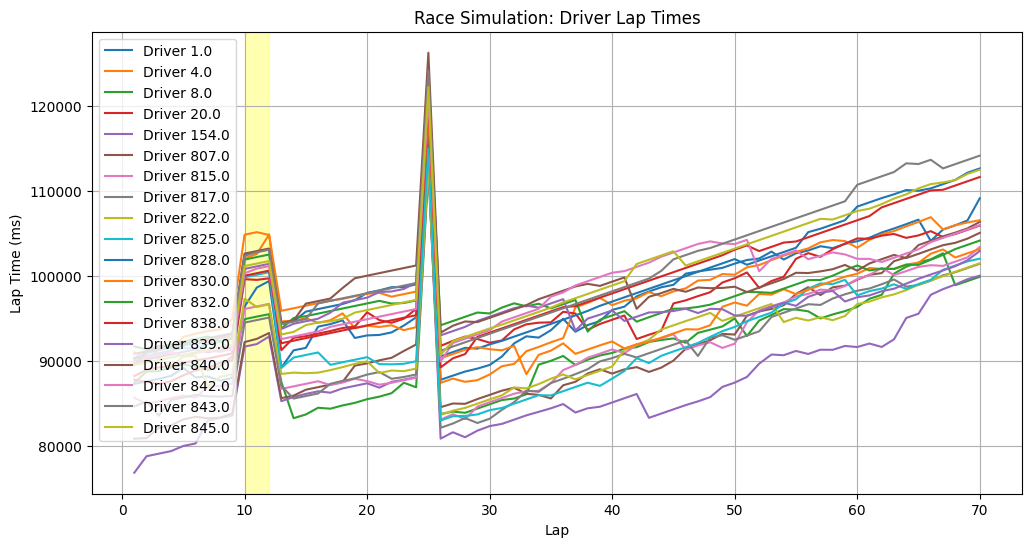

In [2]:
# simulation_linear_regression.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging
from race_simulator_xgboost import (
    Race, Driver, RaceSimulator, plot_race_positions, plot_lap_times
)
from xgboost_utils import load_model_with_preprocessor
import pickle

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load the trained model and preprocessor
model_path = 'models/xgboost_model.pkl'
model, preprocessor = load_model_with_preprocessor(model_path)

# Function to get race length (you can adjust this based on your data)
def get_race_length(race_id: int, lap_times_df: pd.DataFrame) -> int:
    """
    Get the actual race length for a given race ID from historical data.
    """
    race_laps = lap_times_df[lap_times_df['raceId'] == race_id]['lap'].max()
    if pd.isna(race_laps):
        # Fallback to a default length if race not found
        return 50
    return int(race_laps)

# Load necessary data
lap_times = pd.read_csv('data/LAPS.csv', na_values=['\\N', 'NaN', ''])
race_length = get_race_length(1000, lap_times)  # Use your actual race ID

# Create an instance of the Race with actual length
race = Race(
    race_id=1000,
    circuit_id=1,
    total_laps=race_length,
    weather_conditions={},  # Add actual weather data if available
    safety_car_periods=[(10, 12)]  # Example safety car periods
)

# Load driver attributes    
drivers_df = pd.read_csv('data/util/drivers_attributes.csv')

# Define categorical and numerical features (must match training)
categorical_features = ["code", "nationality", "status", "circuit_type", "country"]
preprocessor_transformers = preprocessor.transformers_
if len(preprocessor_transformers) > 0:
    numerical_features = preprocessor_transformers[0][2]  # Assuming 'num' is first
else:
    numerical_features = []
logging.info(f"Numerical features: {numerical_features}")
logging.info(f"Categorical features: {categorical_features}")

def initialize_drivers(drivers_df, preprocessor, race):
    drivers = []

    # Filter driver attributes for the specific raceId
    drivers_race_df = drivers_df[drivers_df['raceId'] == race.race_id]

    if drivers_race_df.empty:
        raise ValueError(f"No drivers found for raceId {race.race_id}")

    for idx, row in drivers_race_df.iterrows():
        # Load driver features from LAPS.csv
        driver_features_df = lap_times[lap_times['driverId'] == row['driverId']]
        
        if driver_features_df.empty:
            raise ValueError(f"No feature data found for driverId {row['driverId']}")

        # For simplicity, take the latest lap's features or aggregate as needed
        driver_features = driver_features_df.iloc[-1].to_dict()

        # Update dynamic features based on simulation requirements
        dynamic_features = {
            'tire_age': 0,
            'fuel_load': 100.0,
            'track_position': idx + 1,
            'TrackTemp': 35.0,
            'AirTemp': 25.0,
            'Humidity': 50.0,
            'TrackStatus': 1,
            'is_pit_lap': 0,
            'tire_compound': 2  # Starting tire compound
        }

        # Combine static and dynamic features
        full_features = driver_features.copy()
        full_features.update(dynamic_features)

        # Ensure all necessary columns are present
        for col in numerical_features + categorical_features:
            if col not in full_features:
                full_features[col] = 0  # Add missing numerical features with zeros or appropriate defaults

        # Extract features needed for the preprocessor
        driver_feature_values = {col: full_features[col] for col in numerical_features + categorical_features}
        driver_df = pd.DataFrame([driver_feature_values])

        # Create the Driver instance
        driver = Driver(
            driver_id=row['driverId'],
            name=row.get('driverName', f"Driver {row['driverId']}"),  # Assuming 'driverName' exists
            static_features=full_features,  # Original features before transformation
            initial_dynamic_features=dynamic_features,
            start_position=idx + 1,
            pit_strategy=[(25, 3)],  # Example pit strategy to switch to soft tires
            starting_compound=2
        )

        drivers.append(driver)

    logging.info(f"Initialized {len(drivers)} drivers for raceId {race.race_id}")
    return drivers

# Initialize drivers using the preprocessor
drivers = initialize_drivers(drivers_df, preprocessor, race)

# Add drivers to the race
race.drivers.extend(drivers)

# Initialize the RaceSimulator with the loaded model and preprocessor
simulator = RaceSimulator(model, preprocessor, model_type='xgboost')

# Simulate the race
race_lap_data = simulator.simulate_race(race)

# Proceed with analysis and plotting
plot_race_positions(race)
plot_lap_times(race)
